In [53]:
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path
import pickle
import re # imports regular expressions
from collections import Counter
import collections
import operator
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
import inflect
from itertools import compress

In [2]:
def get_recipe_df(name):
    '''
    gets the pickled recipe dataframe from the name specified
    '''
    print('Unpickling dataframe')
    
    with open(name,'rb') as f:
        df = pickle.load(f) # save the contents
            
    return df

In [3]:
recipe_df = get_recipe_df('recipe_df.pickle')

Unpickling dataframe


In [5]:
recipe_df.head()

,category,title,serving size,ingredients batch
0,Alcoholic Beverages,Almond Liqueur,1,\r\n 3 cup sugar\r\n 2 1/4 ...
1,Alcoholic Beverages,Cafe Mexicano,8,\r\n 8 cups water; cold\r\n ...
2,Alcoholic Beverages,Coffee Liqueur,1,\r\n 3 cup sugar\r\n 3 ...
3,Alcoholic Beverages,Chartreuse Cocktail,1,\r\n 1 1/2 ounces tequila; 3 T\r\n ...
4,Alcoholic Beverages,Whiskey Sour,1,\r\n 1 lemon; juiced\r\n ...


In [6]:
b = recipe_df['ingredients batch'].copy()
print(f"total number of recipes: {len(b)}")
b.head()

total number of recipes: 5536


0    \r\n       3           cup  sugar\r\n   2 1/4 ...
1    \r\n       8          cups  water; cold\r\n   ...
2    \r\n       3           cup  sugar\r\n       3 ...
3    \r\n   1 1/2        ounces  tequila; 3 T\r\n  ...
4    \r\n       1                lemon; juiced\r\n ...
Name: ingredients batch, dtype: object

In [7]:
def new_get_ingredients(batch,strings_to_skip = None):
    '''
    Takes in a 'batch' of ingredient information, and separates it
    into the quanity, unit, ingredient, and comment portions.
    Returns them as a list of tuples.
    
    Also takes in an arguments strings_to_skip which is a list of strings 
    that if they occur on the line they will be skipped
    '''
    lines = batch.splitlines()[1:] # splits the data into lines to break down
    
    # create the regex patterns to separate the data apart
    quantity_pattern = re.compile(r"(.{8}).*")
    quantity_cleanup_pattern = re.compile(r"\s*(.*)")
    unit_pattern = re.compile(r".{8}(.{14}).*")
    unit_cleanup_pattern = re.compile(r"\s*(.*)")
    measure_pattern = re.compile(r"(\d+ \d/\d|\d+/\d+|\d+)?(?=  ) +?([A-Aa-z]+)?(?=  )", re.S)
    ingredient_info_pattern = re.compile(r".{24}(.*)")
    info_and_comments_pattern = re.compile(r".{24}(.*) +?-- +?(.*)")
    # I still need a way to ignore the 'ingredients' that have 
    # either '----' anywhere (usually is a subtitle)
    # also watch out for 'OR' - could be on it's own line,
    # or inbetween two optional ingredients.
    
    chunk = []
    for line in lines:
        q = quantity_pattern.findall(line)
        u = unit_pattern.findall(line)
        q_n = quantity_cleanup_pattern.findall(q[0])
        if q_n: q_n = q_n[0];
        else: q_n = ''
        u_n = unit_cleanup_pattern.findall(u[0])
        if u_n: u_n = u_n[0];
        else: u_n = ''
                   
        # get the string containing info about the ingredient
        if '--' not in line: # this is the case where a comment on this line
            i = ingredient_info_pattern.findall(line)
            if i: i = i[0];
            else: i = '' # see 'numb' bove for explanation
            c = ''    
        else: # if there is no comment on this line
            i_data = info_and_comments_pattern.findall(line)
            
            i = [text[0] for text in i_data if text[0] !=''];
            if i: i = i[0] # see 'numb' bove for explanation
            else: i: i = ''
                    
            c = [text[1] for text in i_data if text[1] !=''];
            if c: c = c[0]; # see 'numb' bove for explanation
            else: c = ''
        
        chunk.append([q_n,u_n,i,c,i])
    
    return chunk

In [27]:
all_ing_data = [] # we'll collect all the ingredient data here
for i in range(len(b)):
    all_ing_data += [group for group in new_get_ingredients(b.iloc[i])]
print(all_ing_data[:20])    

[['3', 'cup', 'sugar', '', 'sugar'], ['2 1/4', 'cup', 'water', '', 'water'], ['3', '', 'lemons; the rind', 'finely', 'lemons; the rind'], ['', '', 'grated', '', 'grated'], ['1', 'quart', 'vodka', '', 'vodka'], ['3', 'tablespoon', 'almond extract', '', 'almond extract'], ['2', 'tablespoon', 'vanilla extract', '', 'vanilla extract'], ['8', 'cups', 'water; cold', '', 'water; cold'], ['1/3', 'cup', 'dark brown sugar; packed', '', 'dark brown sugar; packed'], ['1/2', 'ounce', 'baking chocolate; fine chop', '', 'baking chocolate; fine chop'], ['2', '', 'cloves; whole', '', 'cloves; whole'], ['1', '', 'cinnamon stick;broken in 1/2', '', 'cinnamon stick;broken in 1/2'], ['1', 'cup', 'coffee; regular grind, dry', '', 'coffee; regular grind, dry'], ['1', 'teaspoon', 'vanilla', '', 'vanilla'], ['1/4', 'cup', 'brandy', '', 'brandy'], ['8', 'tablespoons', 'coffee liqueur', '', 'coffee liqueur'], ['3', 'cup', 'sugar', '', 'sugar'], ['3', 'cup', 'water', '', 'water'], ['3 1/2', 'tablespoon', 'instant

In [28]:
# replace each string element of the ingredients batch column with a dictionary of the information
for i in range(len(recipe_df)):
    recipe_df['ingredients batch'][i] = [group for group in new_get_ingredients(b.iloc[i])]

In order to better search the ingredients for their nutritional value, we need to put all ingredients in their correct general 'ingredient class' that will be a way of normalizing the ingredients: making them so they are all singular, and taking different variations on spelling or word usage to represent the same ingredient and making it clear which ingredient they represent.

 I will need to make a dictionary that will map the old ingredient name to the new ingredient name, so at the end of sorting all the ingredients and choosing out the best classes, I can use the dictionary to find the 'new' category name (the simplified/normalized version.

In [30]:
# normalize all_ingredients by first making everything lowercase
all_ingredients = [all_ing_data[i][2].lower() if all_ing_data[i][2] is not None else '__NONE__' for i in range(len(all_ing_data))]

# create a reference to map from "old names" to the "normalized/class" names
ingredient_class_dict = list(zip([all_ing_data[i][2] for i in range(len(all_ing_data))],all_ingredients))
ingredient_class_dict1 = []
stripped_ingredients = []

# this will be used to singularize plural words
p = inflect.engine()  
for ingredient_pair in ingredient_class_dict:
    
    # for each string, strip the non alphanumeric chars and
    # singularize the word if it is plural
    alph = re.compile('[\W_]+')
    word_list = []
    for w in ingredient_pair[1].split():
        
        # take away the symbols from each word- replace with a space... (see next comment)
        symbol_less = alph.sub(' ', w) 
        
        # so that here when I split again I can have the individual parts
        for wordlet in symbol_less.split(): 
            
            # make the word singular if necessary.
            if p.singular_noun(wordlet): word_list.append(p.singular_noun(wordlet))
            else: word_list.append(wordlet)
    
    ingredient_class_dict1.append([ingredient_pair[0],word_list])

ingredient_class_dict1[:10]

[['sugar', ['sugar']],
 ['water', ['water']],
 ['lemons; the rind', ['lemon', 'the', 'rind']],
 ['grated', ['grated']],
 ['vodka', ['vodka']],
 ['almond extract', ['almond', 'extract']],
 ['vanilla extract', ['vanilla', 'extract']],
 ['water; cold', ['water', 'cold']],
 ['dark brown sugar; packed', ['dark', 'brown', 'sugar', 'packed']],
 ['baking chocolate; fine chop', ['baking', 'chocolate', 'fine', 'chop']]]

In [31]:
# all words will contain a list of every word used in
# the ingredients portions of the recipes
all_words = []
words = [pairs[1] for pairs in ingredient_class_dict1]
for w in words:
    all_words.extend(w)
    
# We create a counter of all words in order to pick out which
# ingredients are the most commonly used to make classes for them
all_words_counter = Counter(all_words)
sorted_all_words = sorted(all_words_counter.items(), key=lambda kv: kv[1],reverse=True)
sum(s[1] for s in sorted_all_words) # this is how many words total I'll be going through

107182

I used the following code to select which words to use to create my general ingredient class names.  I created a list of roughly 200 ingredients, going through the first 455 ingredients to do so.  The reason I stopped at about 200 was because at that point each ingredient was only being used in 11 recipes, and the process is mandatorily time intensive.  I tried to use FuzzyWuzzy before to do fuzzy searching to create the classes.  I found the results worked well, but had too many flaws to easily manage.  Thus the list I ended up creating I then pickled it, and thus I will only unpickle it here, and display it's contents.

raw_to_class = dict()
for s in sorted_all_words[450:455]:
   print(s[0])
   in_y_n = input()
   if in_y_n == 'y':
       raw_to_class[s[0]] = s[0]

In [209]:
with open('hand_sorted_classes.pickle','rb') as f:
        raw_to_class = pickle.load(f) # save the contents

In [266]:
raw_to_class.values()

dict_values(['salt', 'sugar', 'pepper', 'butter', 'flour', 'oil', 'water', 'garlic', 'cheese', 'onion', 'cream', 'milk', 'eggs', 'egg', 'sauce', 'tomato', 'juice', 'lemon', 'chicken', 'vanilla', 'margarine', 'olive', 'parsley', 'celery', 'cinnamon', 'bean', 'corn', 'vinegar', 'mushroom', 'orange', 'chocolate', 'clove', 'bread', 'soda', 'wine', 'beef', 'carrot', 'chili', 'soy', 'rice', 'potato', 'almond', 'ginger', 'basil', 'cornstarch', 'oregano', 'apple', 'broth', 'seed', 'parmesan', 'bell', 'mustard', 'cumin', 'yeast', 'nutmeg', 'raisin', 'peanut', 'pecan', 'breast', 'bay', 'thyme', 'honey', 'cheddar', 'paprika', 'pineapple', 'walnut', 'shortening', 'peel', 'sesame', 'syrup', 'mayonnaise', 'cayenne', 'wheat', 'yolk', 'stock', 'lime', 'unbleached', 'shrimp', 'sherry', 'dill', 'chile', 'fat', 'tuna', 'pea', 'bacon', 'cherry', 'zucchini', 'coconut', 'worcestershire', 'chip', 'pie shell', 'heavy', 'yogurt', 'pork', 'scallion', 'whipping', 'buttermilk', 'coffee', 'cilantro', 'spinach', 'b

In [284]:
# here's how I'm going to create the ingredient classes:
# I will first create a copy of the ingredient batches, call it m
m = ingredient_class_dict1.copy()

# I will also create a dictionary 'n' that will contain the 'translation'
# between raw strings and the 'ingredient classes' we will use
n = dict()

In [283]:
# create a set of which 'groupings' we want to have together
rtc = frozenset(list(raw_to_class))
combos = [rtc.intersection(frozenset(i[1])) for i in m]
combocount = Counter(combos)
combosort = sorted(combocount.items(), key=lambda kv: kv[1],reverse=True)
# goodsets below contains the top combinations.
goodsets = [i[0] for i in combosort[1:260]]
goodsets = goodsets+[frozenset(i) for i in rtc]

In [285]:
# add each combination element in goodsets as a class name
# for a given ingredient description
# if all the elements in are in the description, and 
# that discription does not yet have a class.

for num in range(1,3):
    mask = [len(g)==num for g in goodsets]
    # the clusters will intersect with the same descriptions
    # more than once as num increases; this is ok.  We want them
    # to overwrite the 'simple' for the more 'complex' categories
    clusters = [i for i in list(compress(goodsets,mask))]
    for group in clusters:
        clustername = '_'.join(group)
        for i in m:
            if len(set(group).intersection(set(i[1]))) == num:
                n[i[0]]=clustername

In [293]:
# now go back through and whatever raw ingredient description
# is not already in the dictionary n, map it to 'OTHER'
for i in m:
    if i[0] not in n:
        n[i[0]] = 'OTHER'

In [339]:
# update the ingredients batch information in dataframe so 
# the class information is in the data
for batch in recipe_df['ingredients batch']:
    for ingredients_tuple in batch:
        ingredients_tuple[2] = n[ingredients_tuple[4]]

In [348]:
recipe_df['ingredients batch'][len(recipe_df)-1]

[['6', 'cups', 'water', 'boiling', 'water'],
 ['2', '4 ounce boxe', 'onion', '', 'onion soup mix'],
 ['4', 'ounces', 'spaghetti', 'broken', 'spaghetti'],
 ['1/3', 'cup', 'margarine', '', 'margarine'],
 ['2/3', 'cup', 'onion', '', 'chopped onions'],
 ['1', 'cup', 'bell_pepper', '', 'chopped green bell peppers'],
 ['1 1/2', 'pounds', 'zucchini', '', 'sliced zucchini'],
 ['4', '', 'tomato', 'cut in wedges', 'fresh tomatoes'],
 ['1/4', 'cup', 'parsley', '', 'chopped parsley'],
 ['1/8', 'teaspoon', 'pepper', '', 'black pepper'],
 ['4',
  'cups',
  'mozzarella_cheese',
  '',
  '(2 packages) grated Mozzarella cheese']]

In [351]:
# to add the appropriate columns to the datafame, create them
# all at once, then go through and fill them out as needed.
recipe_df['OTHER'] = np.empty((len(recipe_df), 0)).tolist() # create an 'other' column
                                              # of empty lists to contain
                                              # un-normalized ingredients

In [354]:
for ing_headname in set(n.values()):
    recipe_df['class_' + str(ing_headname)] = None
    recipe_df['unit_' + str(ing_headname)] = None
    recipe_df['quant_' + str(ing_headname)] = None
    recipe_df['comment_' + str(ing_headname)] = None
    recipe_df['ingredient_' + str(ing_headname)] = None

In [355]:
# add the ingredient informaiton to the dataframe if it is normalized,
# otherwise append the information to the 'other' list
for loc,batch in enumerate(recipe_df['ingredients batch']):
    for ingredients_tuple in batch:
        quant, unit, ing_headname, comment, ingredient = ingredients_tuple
        # if the ingredient headname is other, just append the whole tuple
        # into the 'other' list for that recipe.
        if ing_headname == 'OTHER': 
            recipe_df['OTHER'].iloc[loc].append(ingredients_tuple)
        # otherwise, stick the ingredient information in the following columns
        else:
            recipe_df['class_' + str(ing_headname)].iloc[loc] = ing_headname
            recipe_df['unit_' + str(ing_headname)].iloc[loc] = unit
            recipe_df['quant_' + str(ing_headname)].iloc[loc] = quant
            recipe_df['comment_' + str(ing_headname)].iloc[loc] = comment
            recipe_df['ingredient_' + str(ing_headname)].iloc[loc] = ingredient

In [362]:
with open('full_ing_dataframe.pickle','wb') as f:
        pickle.dump(recipe_df,f) # save the contents

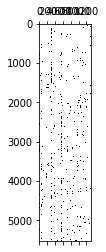

In [365]:
plt.spy(recipe_df.notnull())
plt.show()

In [366]:
len(recipe_df.iloc[0])

1305